In [1]:
import pandas as pd
import json
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

/Users/miladdavoodi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
file1 = "Resources/cleaned_winedf2.csv"
df = pd.read_csv(file1)

In [3]:
df = df.drop(columns=['description', 'province', 'region_1', 'region_2', 'variety', 'type', 'designation', "taster_twitter_handle", "title", 'winery'])
df = df.dropna(subset=['points', 'price'])
df = df[df['price'] < 1000]

In [4]:
file2 = "Resources/new_vs_old.csv"
df2 = pd.read_csv(file2)
df = pd.merge(df, df2, on="country")
df = df.dropna(subset=['taster_name'])
df = df.drop(columns=['country', 'old_vs_new', 'region'])
df

,points,price,taster_name,top_wine_regions
0,86,19,Mike DeSimone,others
2,87,19,Mike DeSimone,others
5,89,21,Mike DeSimone,others
8,89,33,Mike DeSimone,others
11,90,19,Mike DeSimone,others
...,...,...,...,...
378987,89,14,Mike DeSimone,others
378989,90,17,Mike DeSimone,others
378993,87,14,Mike DeSimone,others
378995,88,15,Mike DeSimone,others


# Data Pre-Processing

In [5]:
X = df[['points', 'taster_name', 'top_wine_regions']]
y = df['price'].values.reshape(-1, 1)
print(X.shape, y.shape)

(96404, 3) (96404, 1)


In [6]:
#Use Pandas get_dummies to encode taster_name and top_wine_regions
data = X.copy()

data_encoded = pd.get_dummies(data, columns=['taster_name', 'top_wine_regions'])
# data_encoded = pd.get_dummies(data, columns=['taster_name'])
# data_encoded = data
data_encoded.head()

,points,taster_name_Alexander Peartree,taster_name_Anna Lee C. Iijima,taster_name_Anne Krebiehl MW,taster_name_Carrie Dykes,taster_name_Christina Pickard,taster_name_Fiona Adams,taster_name_Jeff Jenssen,taster_name_Jim Gordon,taster_name_Joe Czerwinski,...,top_wine_regions_Greece,top_wine_regions_Hungary,top_wine_regions_Italy,top_wine_regions_New Zealand,top_wine_regions_Portugal,top_wine_regions_Romania,top_wine_regions_South Africa,top_wine_regions_Spain,top_wine_regions_US,top_wine_regions_others
0,86,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,87,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,89,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,89,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11,90,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


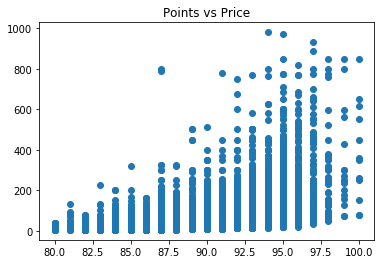

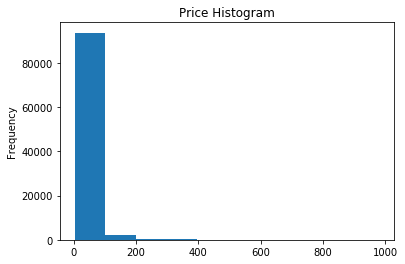

In [7]:
plt.scatter(df['points'], y)
plt.title("Points vs Price")
plt.show()
df.price.plot.hist()
plt.title('Price Histogram')
plt.show()
# df.points.plot.hist()

In [8]:
data

,points,taster_name,top_wine_regions
0,86,Mike DeSimone,others
2,87,Mike DeSimone,others
5,89,Mike DeSimone,others
8,89,Mike DeSimone,others
11,90,Mike DeSimone,others
...,...,...,...
378987,89,Mike DeSimone,others
378989,90,Mike DeSimone,others
378993,87,Mike DeSimone,others
378995,88,Mike DeSimone,others


In [9]:
from sklearn import preprocessing
pt = preprocessing.PowerTransformer(method='box-cox', standardize=False)
X_lognormal = y
price_transformed = pt.fit_transform(X_lognormal)
# X_lognormal
price_transformed

array([[1.90685074],
       [1.90685074],
       [1.94523436],
       ...,
       [1.78183614],
       [1.81115771],
       [1.83800622]])

In [10]:
price_transformed = pd.DataFrame(price_transformed)

In [11]:
data_encoded = data_encoded.reset_index(drop=True)
price_transformed = price_transformed.reset_index(drop=True)

In [12]:
data_encoded = pd.concat([data_encoded, price_transformed], axis=1)
# data_encoded

In [13]:
# data_encoded

In [14]:
data_encoded = data_encoded.rename(columns={0: 'price_transformed'})
# data_encoded.columns

In [15]:
# from sklearn.preprocessing import StandardScaler
# columns_to_scale = [data_encoded.points]
# scaler = StandardScaler
# scaled_columns = scaler.fit_transform(data_encoded['points'])

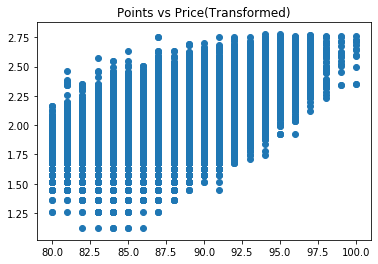

In [16]:
plt.scatter(data_encoded.points, data_encoded.price_transformed)
plt.title('Points vs Price(Transformed)')
plt.show()

In [17]:
# plt.scatter(df.price, data_encoded.price_transformed)
# plt.title('Points vs Price(Transformed)')
# plt.show()

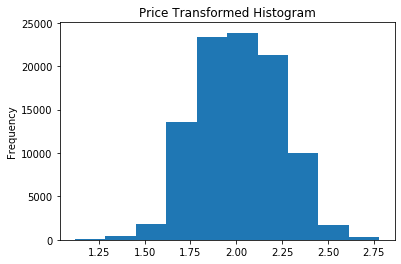

In [18]:
#Run histogram on new transformed Price
data_encoded.price_transformed.plot.hist()
plt.title('Price Transformed Histogram')
plt.show()

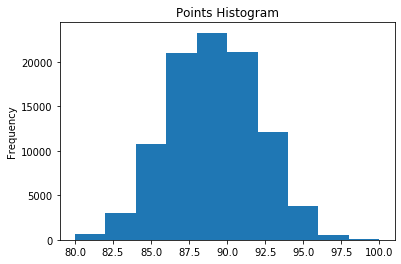

In [19]:
data_encoded.points.plot.hist()
plt.title('Points Histogram')
plt.show()

In [20]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [21]:
X = data_encoded.drop(['price_transformed'], axis='columns')
# X = data_encoded.drop(['price_transformed', 'top_wine_regions', 'taster_name'], axis='columns')
y = data_encoded.price_transformed.values.reshape(-1,1)
print(X.shape, y.shape)

(96404, 37) (96404, 1)


In [22]:
# model.fit(X,y)

In [23]:
X

,points,taster_name_Alexander Peartree,taster_name_Anna Lee C. Iijima,taster_name_Anne Krebiehl MW,taster_name_Carrie Dykes,taster_name_Christina Pickard,taster_name_Fiona Adams,taster_name_Jeff Jenssen,taster_name_Jim Gordon,taster_name_Joe Czerwinski,...,top_wine_regions_Greece,top_wine_regions_Hungary,top_wine_regions_Italy,top_wine_regions_New Zealand,top_wine_regions_Portugal,top_wine_regions_Romania,top_wine_regions_South Africa,top_wine_regions_Spain,top_wine_regions_US,top_wine_regions_others
0,86,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,87,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,89,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,89,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,90,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96399,89,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
96400,90,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
96401,87,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
96402,88,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [24]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(normalize=True)
model.fit(X, y)
# model.fit(X_train_scaled, y_train_scaled)
model.score(X, y)

0.4607121015106825

In [25]:
import numpy as np
from scipy import log
import statsmodels.api as sm
X = sm.add_constant(X)
# X = data_encoded.points
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())
X

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     2353.
Date:                Thu, 07 May 2020   Prob (F-statistic):               0.00
Time:                        21:01:36   Log-Likelihood:                 38647.
No. Observations:               96404   AIC:                        -7.722e+04
Df Residuals:                   96368   BIC:                        -7.688e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

,const,points,taster_name_Alexander Peartree,taster_name_Anna Lee C. Iijima,taster_name_Anne Krebiehl MW,taster_name_Carrie Dykes,taster_name_Christina Pickard,taster_name_Fiona Adams,taster_name_Jeff Jenssen,taster_name_Jim Gordon,...,top_wine_regions_Greece,top_wine_regions_Hungary,top_wine_regions_Italy,top_wine_regions_New Zealand,top_wine_regions_Portugal,top_wine_regions_Romania,top_wine_regions_South Africa,top_wine_regions_Spain,top_wine_regions_US,top_wine_regions_others
0,1.0,86,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,87,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1.0,89,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1.0,89,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1.0,90,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96399,1.0,89,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
96400,1.0,90,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
96401,1.0,87,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
96402,1.0,88,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
res

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [ ]:
ml = data
ml.taster_name = le.fit_transform(ml.taster_name)
ml.top_wine_regions = le.fit_transform(ml.top_wine_regions)
# data
ml

In [ ]:
X = ml[['points', 'taster_name', 'top_wine_regions']].values
y = ml['price']
X

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(categorical_features=[1,2])

In [ ]:
import warnings
warnings.filterwarnings("ignore")
X = ohe.fit_transform(X).toarray()
print(X.shape)
# X = X[:,1:]

In [ ]:
model.fit(X,y)
model.score(X,y)

# BREAK

In [ ]:
X.values.reshape(-1,1).astype

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train.head()


In [ ]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler().fit(X.reshape(-1,1))
y_scaler = StandardScaler().fit(y.reshape(-1,1))

In [ ]:
#Tranform the training adn testing data using the X_scaler and y_scaler models

###Begin solution
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [ ]:
#Creat a LinearRegression model and fit it to the scaled training data

# from sklearn.linear_model import LinearRegression
# model = LinearRegression()
# model.fit(X_train_scaled, y_train_scaled)
import statsmodels.api as sm
mod = sm.OLS(X_train_scaled, y_train_scaled)
res = mod.fit()
print(res.summary())


In [ ]:
### BEGIN SOLUTION
predictions = model.predict(X_test_scaled)
model.fit(X_train_scaled, y_train_scaled)
plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Residual Plot")
plt.show()
### END SOLUTION

In [ ]:
### BEGIN SOLUTION
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = model.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

In [ ]:
#OneHotEncode to encode taster and region to model
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(data.taster_name)
taster = label_encoder.transform(data.taster_name)

In [ ]:
from keras.utils import to_categorical
encoded_taster = to_categorical(taster)
encoded_taster

In [ ]:
label_encoder.fit(data.top_wine_regions)
regions = label_encoder.transform(data.top_wine_regions)

In [ ]:
encoded_region = to_categorical(regions)
encoded_region

In [ ]:
points = data['points'].reset_index(drop=True)
points

In [ ]:
data1 = data.drop(columns='points')
data

In [ ]:
from sklearn.preprocessing import OneHotEncoder
data1 = OneHotEncoder().fit_transform(data)

In [ ]:
data1.todense()
print(data1[:,1])


In [ ]:
#We now have price_transformed, encoded_taster, and encoded_region to analysize 
X = [data1, points]
y = price_transformed
print(data1.shape)

In [ ]:
plt.figure(figsize = (12, 8))
sns.heatmap(df.corr(), annot = True, cmap = 'viridis_r')
plt.title("Correlation Heatmap")

In [ ]:
y = df['price']
X = df['points']

#BOX-COX Transform
from scipy.stats import boxcox
#define data
#box-cox transform
y, lmbda = boxcox(y)

#Invert Box-cox
from math import log
from math import exp
#invert a boxcox transform for one value
def invert_boxcox(value, lam):
    #log case
    if lam ==0:
        return exp(value)
    #all other cases
    return exp(log(lam * value + 1) / lam)

import numpy as np
import statsmodels.api as sm

mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())